In [2]:
# coding: utf-8

# In[3]:
from ThePablos import *
import random
import matplotlib.pyplot as plt
import time
import math
from deap import base, creator, tools, algorithms
%matplotlib inline

Start of evolution
  Evaluated 500 individuals
-- End of (successful) evolution --
Time Elapsed: 
10.381884

-- Punto final generado --
[ 1.00000014  1.00000022  2.00000111]
-- Punto final real --
[ 1.  1.  2.]
-- Error --
1.29560804523e-12
-- Energia --
60169.8991461


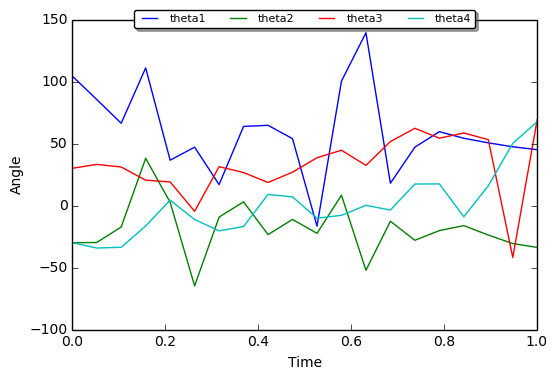

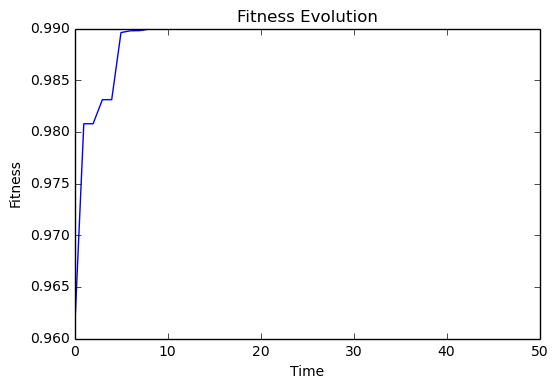

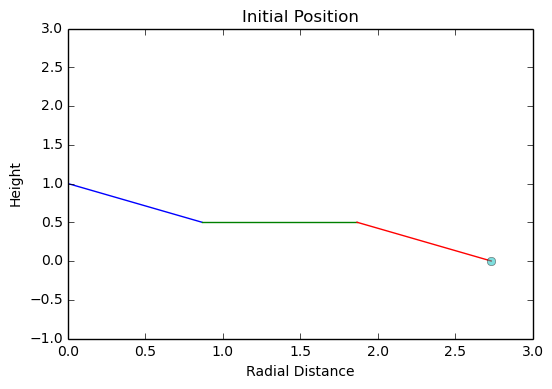

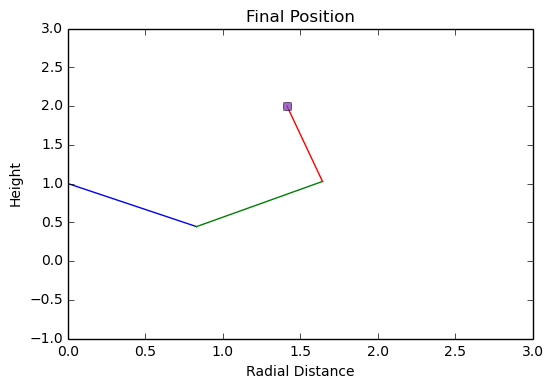

In [24]:
####---------------------- PARAMETROS ---------------------- #####

#Posiciones en que se discretizan los caminos
Npos = 20
#Numero de generaciones
Ng = 50
#Numero de individuos en la poblacion
Npop = 500
#Duracion del movimiento
t_mov = 1
#Ponderacion de la energia en el fitness
lam = 1e-2

#Probabilidades de recombinacion y mutacion
Pci = 0.9 #cada individuo
Pcc = 0.9 #cada atributo
Pmi = 0.5
Pmc = 0.1

cotainf = np.array([-180,-90,-90,-90])*np.pi/180
cotamax = np.array([180,90,90,90])*np.pi/180
l1 = 1
l2 = 1
l3 = 1
l4 = 1
r = 1e-2

#Simulador de robot
robotArm = ThePablos(l1, l2, l3, l4, r, t_mov)

largobrazos = np.array([1,1,1,1])
masas = np.array([1,1,1,1])

tiempo = np.linspace(0.0,t_mov,num=Npos)
delta = np.diff(tiempo)

#configuracion inicial de angulos
condborde=np.array([90, -30, 30, -30])*np.pi/180

#Posicion target
#x,y,z plano cartesiano
#finalpos=np.array([1.93, 1.93, 1.0])
#finalpos=np.array([0, 0, 0])
finalpos=np.array([1.0, 1.0, 2.0])


toolbox = base.Toolbox()


####---------------------- DEFINICION DE OPERADORES----------------------- #####


#Generar la funcion suave que intentara formar cada fila de angulo por trayectoria
def curvegenerator(low,high,Npos, izq = None, der = None):
    curva = list()
    if izq == None : izq =random.uniform(low,high)
    if der == None: der =random.uniform(low,high)
    #izq es en teoria el theta_h supra j (1),   der theta_h supra j (Npos)   
    R = (der - izq)
    A = random.uniform(-3*abs(R), 3*abs(R)) 
    mu = random.uniform(2, Npos - 1)
    sigma = random.uniform(1, Npos/6.0)
    
    for i in range(1, Npos+1):
        curva.append(izq + (R/(Npos -1))*(i-1)+ A*np.exp((-1*(i-mu)**2)/2*sigma**2));
        #Verificar restricciones
        if curva[i-1] > high:  curva[i-1] = high
        if curva[i-1] < low:   curva[i-1] = low
    
    return curva

# Registra rand_tanh, que genera las curvas de posición angular, sujetas a
# condiciones de borde
xf = finalpos[0]
yf = finalpos[1]

if xf > 0: theta1_f = math.atan(yf/xf)
elif xf < 0: theta1_f = np.pi+math.atan(yf/xf)
else: theta1_f = np.pi/2

if theta1_f > np.pi: theta1_f -= 2*np.pi
    
toolbox.register("rand_theta1",curvegenerator,cotainf[0],cotamax[0],Npos,
                 condborde[0], theta1_f)
toolbox.register("rand_theta2",curvegenerator,cotainf[1],cotamax[1],Npos,
                 condborde[1])
toolbox.register("rand_theta3",curvegenerator,cotainf[2],cotamax[2],Npos,
                 condborde[2])
toolbox.register("rand_theta4",curvegenerator,cotainf[3],cotamax[3],Npos,
                 condborde[3])


#Creacion de la poblacion

#creator.create("FitnessMulti", base.Fitness, weights=(-1.0,10.0))
#creator.create("FitnessMulti", base.Fitness, weights=(1.0,)) #maximizar
creator.create("FitnessMulti", base.Fitness, weights=(-1.0,)) #minimizar
creator.create("Individual", np.ndarray, fitness=creator.FitnessMulti)

# Los individuos consisten de 4 curvas generadas al azar
generate = [toolbox.rand_theta1, toolbox.rand_theta2, toolbox.rand_theta3,
            toolbox.rand_theta4]
toolbox.register("individual", tools.initCycle, creator.Individual, generate)

# Define la población de individuos
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


#Fitness

def evaluatePath(individual):
    global finalpos
    global robotArm
    global lam
    
    robotArm.setPath(individual[0], individual[1], individual[2], individual[3])
    robotArm.angularCons()
    finalGenerado = robotArm.endPoint()
    energia = robotArm.getEnergySim()
    
    fitness1 = mse(finalGenerado, finalpos)
    #fitness1 = 1/(1+mse(finalGenerado, finalpos))
    #fitness1 = kernel(finalGenerado, finalpos,5)
    
    fitness2 = energia
    #fitness2 = 1/(1+energia)
    #fitness2 = kernel(np.array([energia]), np.zeros(1),sigmaEnergy)
    
    fitness = (1-lam)*fitness1 + lam*fitness2
    #return fitness1 , fitness2
    return fitness,

def kernel(X,Y,sigma):
    k =  np.exp(-sum((X-Y)**2) / (2*(sigma**2)))
    return k

def mse(x,y):
    return sum(abs((x-y)**2))


#Operador de crossover
def mate_continuum(indiv1, indiv2, pcros):
    Ns = len(indiv1[0])
    #Se crea una variable auxiliar para no perder punteros.
    aux1 = toolbox.clone(indiv1)
    aux2 = toolbox.clone(indiv2)
    
    for angulo in range(len(indiv1)): 
        if random.random() < pcros :   #Entra a la condicion para recombinar la curva
            mu = random.uniform(2,Ns-1)
            sigma = random.uniform(1, Ns/6.0)
            W = [0.5 * (1 + math.tanh((k-mu)/sigma))    for k in range(Ns) ]
            for i in range(1,Ns):                       
                indiv1[angulo][i] = W[i]*aux1[angulo][i] + (1-W[i])*aux2[angulo][i]
                indiv2[angulo][i] = (1-W[i])*aux1[angulo][i] + W[i]*aux2[angulo][i]
    return (indiv1, indiv2)            

# Define la mutación continua
def cont_mutate(ind, pmc, low, high):
    Ns = len(ind[0])
    for c in range(len(ind)):
        izq = low[c]
        der = high[c]
        if random.random() < pmc:
            mu = random.uniform(2,Ns-1)
            sigma = random.uniform(1, Ns/6.0)
            M = [np.exp(-(k-mu)**2/(2*sigma**2))   for k in range(Ns)]                     
            for i in range(1,Ns):
                vecindad = abs(der - izq)
                alpha = random.uniform(-vecindad, vecindad)
                ind[c][i] += alpha*M[i]
                #Verificar restricciones
                if ind[c][i] > high[c]:  ind[c][i] = high[c]
                if ind[c][i] < low[c]:  ind[c][i] = low[c]
    return ind


# Registra el operador de recombinación
toolbox.register("mate", mate_continuum, pcros=Pcc)
# Registra el operador de mutación 
toolbox.register("mutate", cont_mutate, pmc=Pmc, low = cotainf,
                 high=cotamax )

# Registra selección por torneo
toolbox.register("select", tools.selTournament, tournsize=3)

toolbox.register("evaluate", evaluatePath)



####---------------------- ALGORITMO GENETICO ----------------------- #####


def main():
    startToooodo = time.clock()
    pop = toolbox.population(n=Npop)
    print("Start of evolution")
     # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    print("  Evaluated %i individuals" % len(pop))
    
    max1 = np.zeros(Ng)
    min1 = np.zeros(Ng)
    prom1 = np.zeros(Ng)
    max2 = np.zeros(Ng)
    min2 = np.zeros(Ng)
    prom2 = np.zeros(Ng)
    
    # Begin the evolution
    for g in range(Ng):
        
        #print("-- Generation %i --" % g)
        #start = time.clock()
        
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))
        besties = tools.selBest(pop, 1)
        best1 = besties[0]
        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            # cross two individuals with probability CXPB
            if random.random() < Pci:
                toolbox.mate(child1, child2)
                # fitness values of the children
                # must be recalculated later
                del child1.fitness.values
                del child2.fitness.values
        
        for mutant in offspring:
            #    mutate an individual with probability MUTPB
            if random.random() < Pmi:
                toolbox.mutate(mutant)
                del mutant.fitness.values
                
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit 
        
        #print("  Evaluated %i individuals" % len(invalid_ind))
         # The population is entirely replaced by the offspring
        pop[:] = offspring
        indaux = np.random.randint(0, len(pop))
        pop[indaux] = best1 #Elitismo
        
        fits1 = [ind.fitness.values[0] for ind in pop]
        #fits2 = [ind.fitness.values[1] for ind in pop]
        length = len(pop)
        max1[g]= np.max(fits1)
        #max2[g] = np.max(fits2)
        min1[g] = np.min(fits1)
        #min2[g] = np.min(fits2)
        prom1[g] = np.sum(fits1) /length
        #prom2[g] = np.sum(fits2)/ length
        
        #end = time.clock()
        #print "Time Elapsed: "
        #print(end-start)
        #print ""
    print("-- End of (successful) evolution --")
    
    best_ind = tools.selBest(pop, 1)[0]
    #print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))
    endToooodo = time.clock()
    print "Time Elapsed: "
    print(endToooodo-startToooodo)
    print ""
    #return best_ind, max1, max2, min1, min2, prom1, prom2
    return best_ind, max1, min1, prom1
    

####---------------------- VISUALIZACION DE RESULTADOS ----------------------- #####    
    

if __name__ == "__main__":
    #best, max1, max2, min1, min2, prom1, prom2 = main()
    best, max1, min1, prom1 = main()
    tiempo = np.linspace(0.0,t_mov,num=Npos)
    thetaWinA = best[0]
    thetaWinB = best[1]
    thetaWinC = best[2]
    thetaWinD = best[3]
    robotArm.setPath(thetaWinA, thetaWinB, thetaWinC, thetaWinD)
    robotArm.angularCons()
    
    #Trayectoria
    
    plt.figure(1)
    plt.plot(tiempo, thetaWinA*180/np.pi, label="theta1")
    plt.plot(tiempo, thetaWinB*180/np.pi, label="theta2")
    plt.plot(tiempo, thetaWinC*180/np.pi, label="theta3")
    plt.plot(tiempo, thetaWinD*180/np.pi, label="theta4")
    plt.xlabel("Time")
    plt.ylabel("Angle")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=4, fancybox=True, shadow=True, prop={'size':8})
    
    #Evolucion fitness
    
    lablox = range(Ng)
    plt.figure(2)
    #plt.subplot(211)
    plt.plot(lablox,max1, label = "Maximo")
    #plt.plot(lablox,min1, label = "Minimo")
    #plt.plot(lablox,prom1, label = "Promedio")
    plt.xlabel("Time")
    plt.ylabel("Fitness")
    plt.title("Fitness Evolution")
    #plt.legend(loc="lower left")
    
    #plt.subplot(212)
    #plt.plot(lablox,max2, label = "Maximo")
    #plt.plot(lablox,min2, label = "Minimo")
    #plt.plot(lablox,prom2, label = "Promedio")
    #plt.xlabel("Time")
    #plt.ylabel("Fitness2")
    #plt.title("Fitness Evolution")
    #plt.legend(loc="lower left")
    
    
    finalGenerado = robotArm.endPoint()
    energia = robotArm.getEnergySim()
    print("-- Punto final generado --")
    print finalGenerado
    print("-- Punto final real --")
    print finalpos
    print("-- Error --")
    print mse(finalGenerado,finalpos)
    print("-- Energia --")
    print energia
    
    #Posicion inicial robot
    plt.figure(3)
    puntitos = robotArm.getExtremos(0)
    dataR = puntitos[0]
    dataZ = puntitos[1]
    plots = [ plt.plot(dataR[i:i+2],dataZ[i:i+2]) for i in range(3)  ]
    plt.plot(dataR[-1],dataZ[-1],'o',alpha=0.5)
    plt.xlim([0,3])
    plt.ylim([-1,3])
    plt.xlabel("Radial Distance")
    plt.ylabel("Height")
    plt.title("Initial Position")
    
    #Posicion final robot
    plt.figure(4)
    puntitos = robotArm.getExtremos(-1)
    dataR = puntitos[0]
    dataZ = puntitos[1]
    plots = [ plt.plot(dataR[i:i+2],dataZ[i:i+2]) for i in range(3)  ]
    rDeseado = np.sqrt(finalpos[0]**2+finalpos[1]**2)
    zDeseado = finalpos[2]
    plt.plot(dataR[-1],dataZ[-1],'o',alpha=0.5)
    plt.plot(rDeseado,zDeseado,'s',alpha=0.5)
    plt.xlim([0,3])
    plt.ylim([-1,3])
    plt.xlabel("Radial Distance")
    plt.ylabel("Height")
    plt.title("Final Position")
    
    plt.show()